<a href="https://colab.research.google.com/github/ssubbinn/Project/blob/main/%EC%B0%90%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파일 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
plt.rc('font', family='NanumBarunGothic')
sns.set(font="NanumGothic")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
wonju = pd.read_csv("/content/drive/MyDrive/빅콘테스트와플핑/0.데이터/원주 데이터/last_predict_result.csv")
wonju = wonju.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
wonju.head()

<ipython-input-21-df4b5d684422>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wonju = wonju.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


,native_1,end_time,gender,age,day_of_week,purpose_combi,is_holiday,predicted_od_cnts
0,0,08,0,1,0,04,0,12.208000
1,0,08,0,1,1,44,0,2.476000
2,0,08,0,1,2,44,0,4.617000
3,0,08,0,1,4,04,0,9.894000
4,0,08,0,1,4,44,0,2.724333


In [ ]:
wonju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14146 entries, 0 to 14145
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   native_1           14146 non-null  object 
 1   end_time           14146 non-null  object 
 2   gender             14146 non-null  object 
 3   age                14146 non-null  object 
 4   day_of_week        14146 non-null  object 
 5   purpose_combi      14146 non-null  object 
 6   is_holiday         14146 non-null  object 
 7   predicted_od_cnts  14146 non-null  float64
dtypes: float64(1), object(7)
memory usage: 884.2+ KB


# 시나리오 1


## Native 여부

native_1
0      6281.274167
1    103612.036833
Name: predicted_od_cnts, dtype: float64


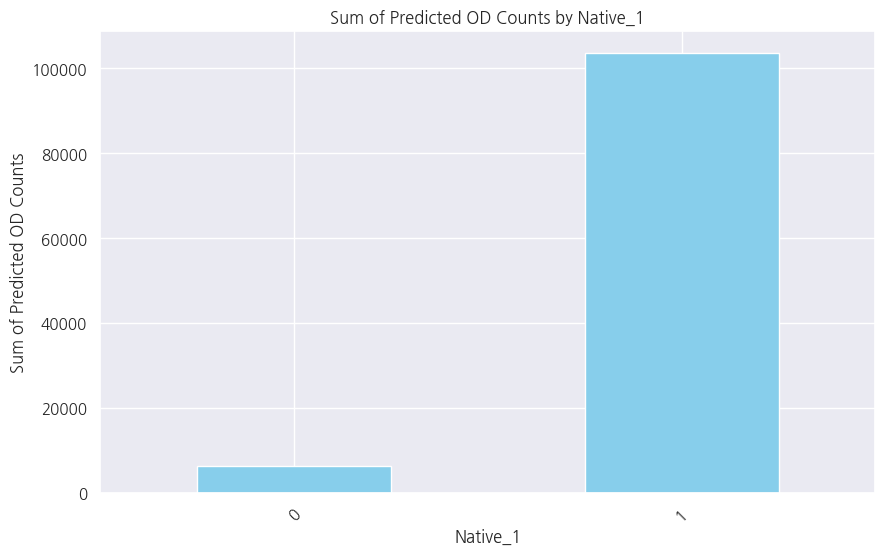

In [ ]:
# native_1을 기준으로 predicted_od_cnts 합계 계산
native_od_sum = wonju.groupby('native_1')['predicted_od_cnts'].sum()
print(native_od_sum)

# 그래프 그리기
plt.figure(figsize=(10, 6))
native_od_sum.plot(kind='bar', color='skyblue')
plt.title('Sum of Predicted OD Counts by Native_1')
plt.xlabel('Native_1')
plt.ylabel('Sum of Predicted OD Counts')
plt.xticks(rotation=45)
plt.show()

In [ ]:
103612.036833/6281.274167

16.49538518432259

원주 내에서 많이 오니까 가까운 근거리 이동을 하는 사람을 대상으로 할인행사를 하세요

## MZ세대

### 요일별 보기

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

mz_data_grouped = mz_data.groupby(['day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

# 요일별로 weighted_od_cnts의 합을 특정 숫자로 나누는 함수
def divide_weighted_od_cnts(day_of_week, total_weighted_od_cnts):
    # day_of_week이 0, 1, 2, 3인 경우 6으로 나누고, 4, 5, 6인 경우 7로 나눔
    divisor = 6 if day_of_week in ['0', '1', '2', '3'] else 7
    return total_weighted_od_cnts / divisor

# weighted_od_cnts의 합을 구한 뒤 요일에 따라 나눔
mz_data_grouped['adjusted_weighted_od_cnts'] = mz_data_grouped.groupby('day_of_week')['weighted_od_cnts'] \
    .transform(lambda x: divide_weighted_od_cnts(x.name, x.sum()))

# 불필요한 열 제거 및 중복 행 제거
mz_data_grouped = mz_data_grouped.drop(columns=['is_holiday', 'predicted_od_cnts', 'weighted_od_cnts']).drop_duplicates()
mz_data_grouped

,day_of_week,adjusted_weighted_od_cnts
0,0,160.908778
2,1,162.062778
4,2,161.692667
5,3,209.332083
7,4,213.429000
9,5,242.751905
11,6,170.484643


   day_of_week  adjusted_weighted_od_cnts
0            0                 160.908778
2            1                 162.062778
4            2                 161.692667
5            3                 209.332083
7            4                 213.429000
9            5                 242.751905
11           6                 170.484643


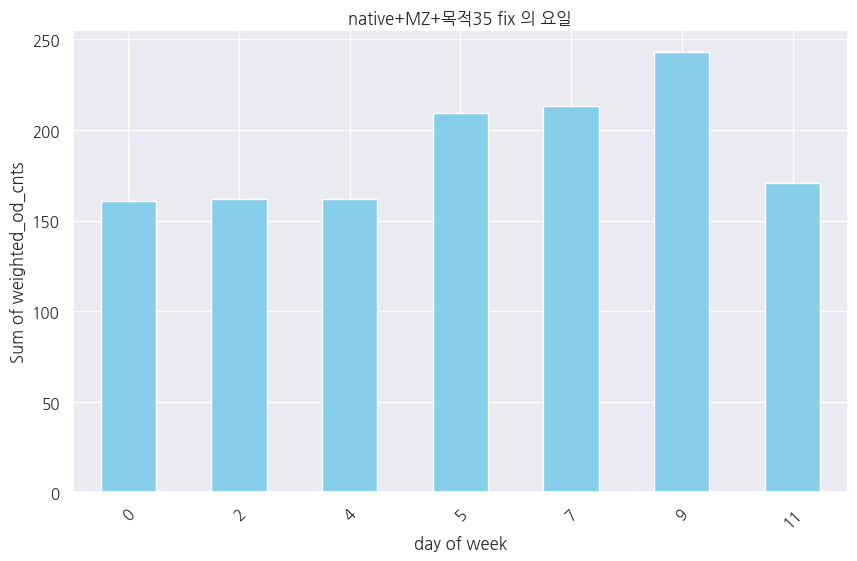

In [ ]:
# 막대 그래프 그리기
print(mz_data_grouped)
plt.figure(figsize=(10, 6))
mz_data_grouped['adjusted_weighted_od_cnts'].plot(kind='bar', color='skyblue')
plt.xlabel('day of week')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+MZ+목적35 fix 의 요일')
plt.xticks(rotation=45)
plt.show()

### 목요일

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))&
                      (wonju['day_of_week']=='3')]

mz_data_grouped = mz_data.groupby(['end_time', 'is_holiday', 'day_of_week']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/6
mz_time.head(20)

,weighted_od_cnts
end_time,
09,15.469861
10,10.606389
11,17.756528
12,20.118889
13,25.386111
14,10.546111
15,16.561944
16,10.446667
17,12.963750


end_time
09    15.469861
10    10.606389
11    17.756528
12    20.118889
13    25.386111
14    10.546111
15    16.561944
16    10.446667
17    12.963750
18    26.190694
19     9.904306
20    11.539306
21    11.966250
22     8.405278
23     1.470000
Name: weighted_od_cnts, dtype: float64


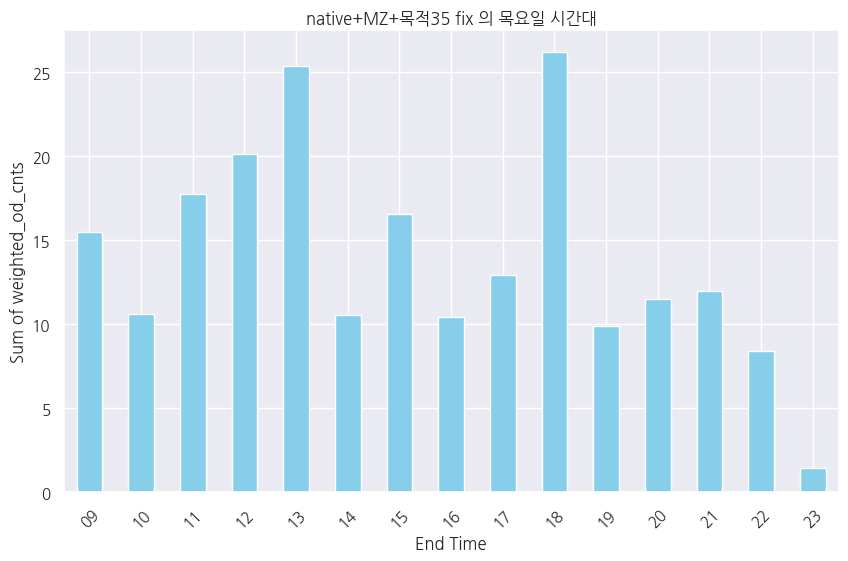

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+MZ+목적35 fix 의 목요일 시간대')
plt.xticks(rotation=45)
plt.show()

### 토요일

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))&
                      (wonju['day_of_week']=='5')]

mz_data_grouped = mz_data.groupby(['end_time', 'is_holiday', 'day_of_week']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/7
mz_time.head(20)

,weighted_od_cnts
end_time,
08,1.898571
09,10.731429
10,21.352619
11,18.027857
12,15.392619
13,21.119405
14,22.752976
15,18.798452
16,20.773571


end_time
08     1.898571
09    10.731429
10    21.352619
11    18.027857
12    15.392619
13    21.119405
14    22.752976
15    18.798452
16    20.773571
17    14.532143
18    33.271548
19    19.756667
20    12.937619
21     6.346429
22     4.131429
23     0.928571
Name: weighted_od_cnts, dtype: float64


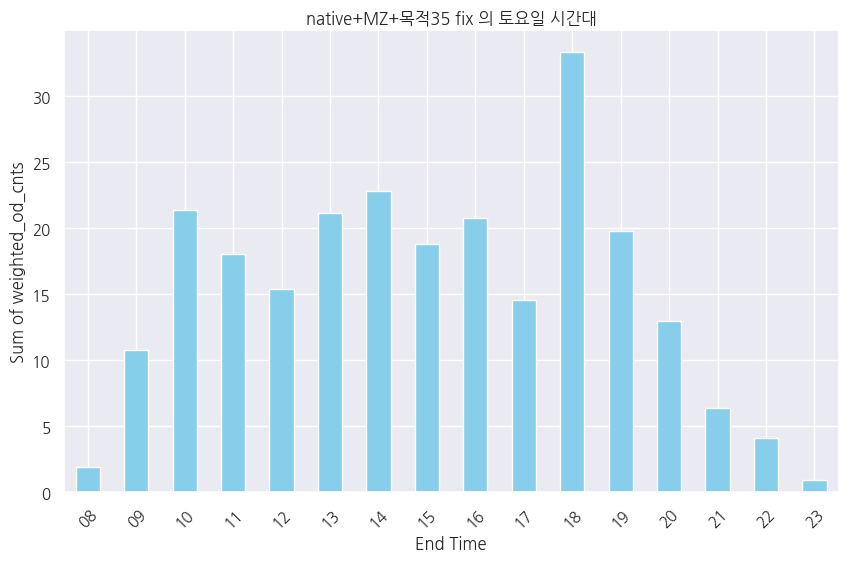

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+MZ+목적35 fix 의 토요일 시간대')
plt.xticks(rotation=45)
plt.show()

### 시간대별 보기

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

mz_data_grouped = mz_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08     2.100726
09    12.580815
10    17.968796
11    16.498019
12    15.546944
13    19.745937
14    15.417819
15    14.303333
16    10.382870
17    11.777178
18    21.491822
19    13.678115
20     8.255296
21     6.107600
22     3.357900
23     0.800978
Name: weighted_od_cnts, dtype: float64


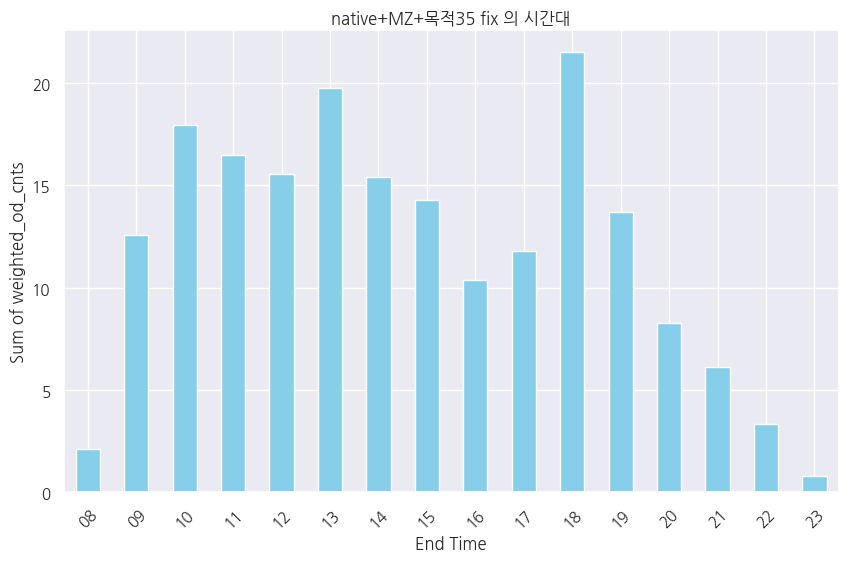

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+MZ+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('0', '1', '2')))]

mz_data_grouped = mz_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08    248.441322
09     82.948293
10     50.717563
11     58.576593
12    114.260259
13    116.020096
14     58.316396
15     64.190741
16     62.908615
17     80.778804
18     98.632941
19     76.315181
20     77.286174
21     72.371715
22     61.699311
23     25.380007
Name: weighted_od_cnts, dtype: float64


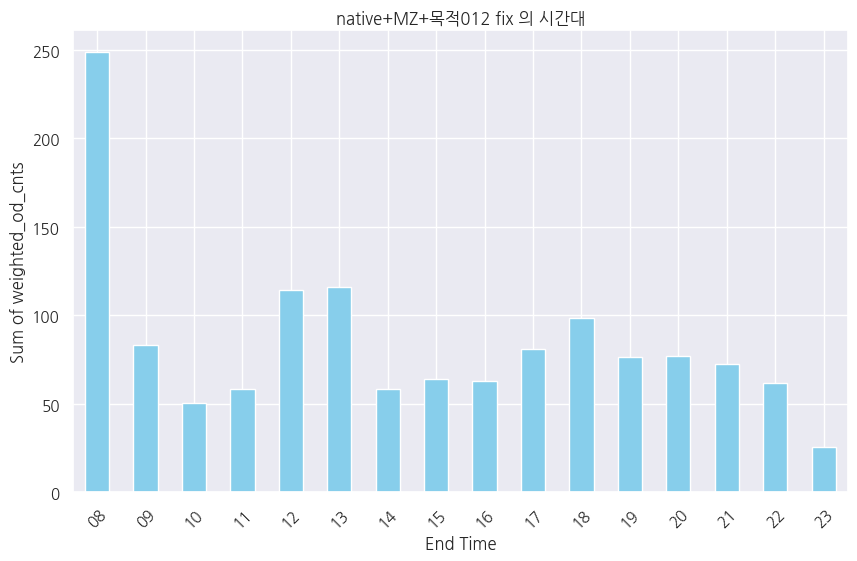

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+MZ+목적012 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

뭐 자주오는 요일 이런건 없나요?

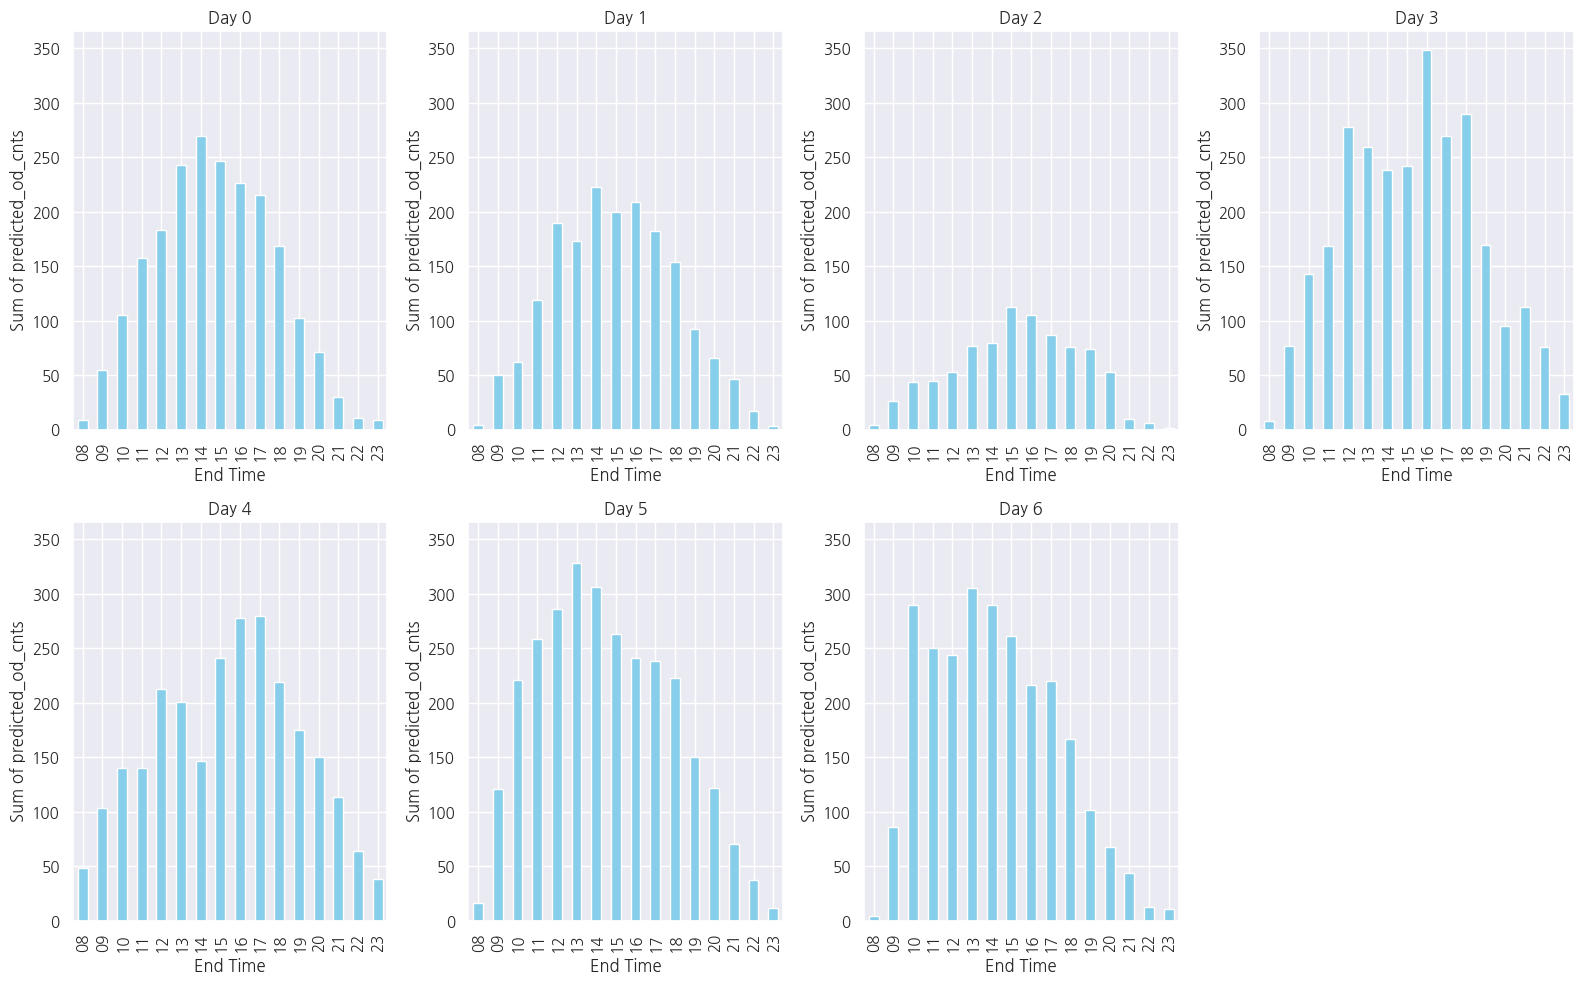

In [ ]:
# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
filtered_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['1', '2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

# day_of_week별 end_time에 대한 predicted_od_cnts 값의 합 계산
day_time_sum = filtered_data.groupby(['day_of_week', 'end_time'])['predicted_od_cnts'].sum().reset_index()

# 그래프 크기 설정 (2x4 행렬로 설정, 빈 공간을 남기기 위해 8개를 준비)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

# 고유한 day_of_week 값 (0부터 6까지)
unique_days = sorted(day_time_sum['day_of_week'].unique())

# y축의 최대값 계산 (모든 그래프에서 동일하게 사용)
y_max = day_time_sum['predicted_od_cnts'].max() * 1.05

# 각 day_of_week에 대해 그래프 그리기
for i, day in enumerate(unique_days):
    # 해당 day_of_week에 맞는 데이터 필터링
    day_data = day_time_sum[day_time_sum['day_of_week'] == day]

    # end_time별 predicted_od_cnts 값의 합 계산
    ax = axes[i // 4, i % 4]  # 2x4 행렬로 그래프 위치 설정
    day_data.plot(kind='bar', x='end_time', y='predicted_od_cnts', ax=ax, color='skyblue', legend=False)

    # 그래프에 레이블 추가
    ax.set_xlabel('End Time')
    ax.set_ylabel('Sum of predicted_od_cnts')
    ax.set_title(f'Day {day}')

    # y축을 동일하게 맞추기
    ax.set_ylim(0, y_max)

# 마지막 subplot 위치는 비워두기 (7개의 그래프만 표시)
axes[1, 3].axis('off')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()


절대적인 이동량은 목금토일이 많은거같고, 마지막 두장이 토, 일 주말이거든? 아침쪽에 많이 이동하는거같네? 참고하렴

공휴일별로도 좀 알고싶은데, 공휴일 여부는 영향이 없나..?

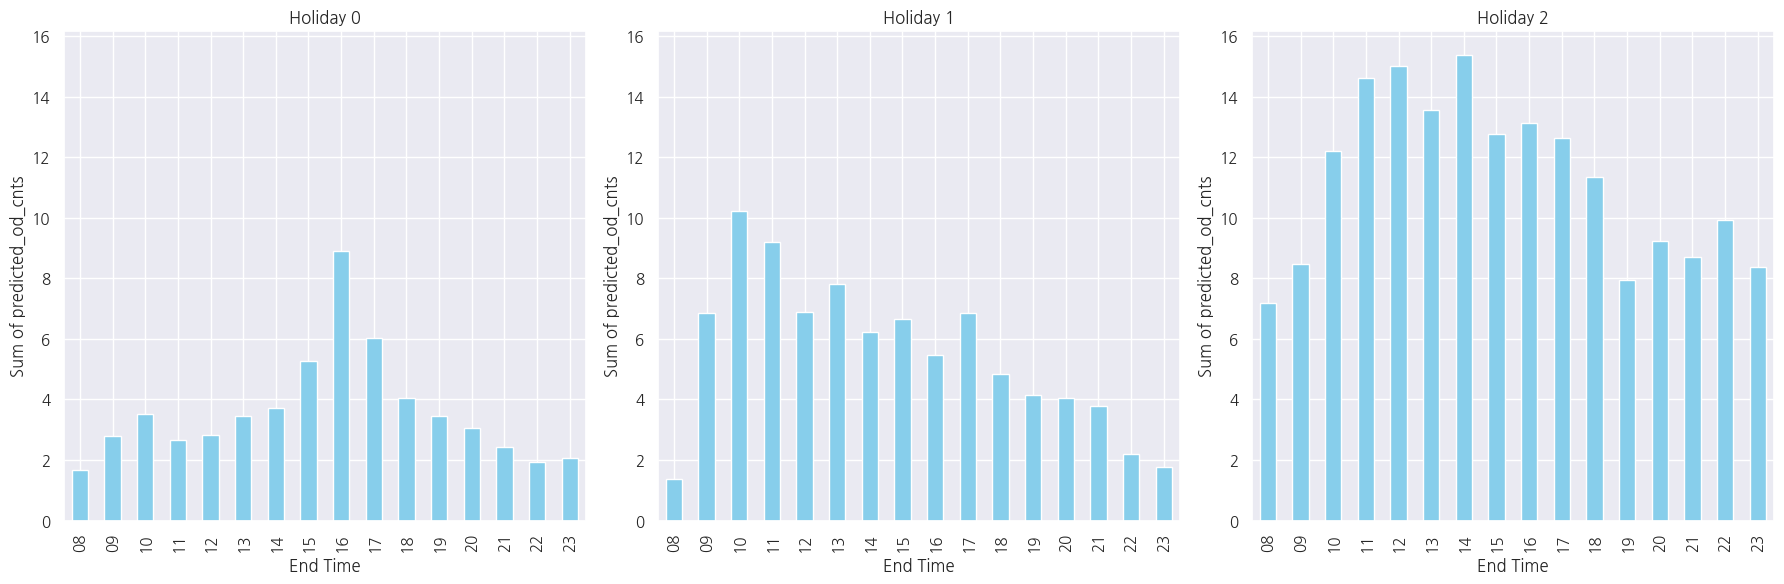

In [ ]:
# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
filtered_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['1', '2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

# is_holiday별 end_time에 대한 predicted_od_cnts 값의 합 계산
holiday_time_sum = filtered_data.groupby(['is_holiday', 'end_time'])['predicted_od_cnts'].mean().reset_index()

# 그래프 크기 설정 (1x3 행렬로 설정)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 고유한 is_holiday 값 (0, 1, 2)
unique_holidays = sorted(holiday_time_sum['is_holiday'].unique())

# y축의 최대값 계산 (모든 그래프에서 동일하게 사용)
y_max = holiday_time_sum['predicted_od_cnts'].max() * 1.05

# 각 is_holiday에 대해 그래프 그리기
for i, holiday in enumerate(unique_holidays):
    # 해당 is_holiday에 맞는 데이터 필터링
    holiday_data = holiday_time_sum[holiday_time_sum['is_holiday'] == holiday]

    # end_time별 predicted_od_cnts 값의 합 계산
    ax = axes[i]  # 1x3 행렬로 그래프 위치 설정
    holiday_data.plot(kind='bar', x='end_time', y='predicted_od_cnts', ax=ax, color='skyblue', legend=False)

    # 그래프에 레이블 추가
    ax.set_xlabel('End Time')
    ax.set_ylabel('Sum of predicted_od_cnts')
    ax.set_title(f'Holiday {holiday}')

    # y축을 동일하게 맞추기
    ax.set_ylim(0, y_max)

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()


## OLD 세대

### 요일별 보기

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
old_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['4', '5'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

old_data_grouped = old_data.groupby(['day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
old_data_grouped['weighted_od_cnts'] = old_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

# 요일별로 weighted_od_cnts의 합을 특정 숫자로 나누는 함수
def divide_weighted_od_cnts(day_of_week, total_weighted_od_cnts):
    # day_of_week이 0, 1, 2, 3인 경우 6으로 나누고, 4, 5, 6인 경우 7로 나눔
    divisor = 6 if day_of_week in ['0', '1', '2', '3'] else 7
    return total_weighted_od_cnts / divisor

# weighted_od_cnts의 합을 구한 뒤 요일에 따라 나눔
old_data_grouped['adjusted_weighted_od_cnts'] = old_data_grouped.groupby('day_of_week')['weighted_od_cnts'] \
    .transform(lambda x: divide_weighted_od_cnts(x.name, x.sum()))

# 불필요한 열 제거 및 중복 행 제거
old_data_grouped = old_data_grouped.drop(columns=['is_holiday', 'predicted_od_cnts', 'weighted_od_cnts']).drop_duplicates()
old_data_grouped

,day_of_week,adjusted_weighted_od_cnts
0,0,460.063556
2,1,550.603472
4,2,536.677667
5,3,618.090417
7,4,537.163714
9,5,572.539881
11,6,455.782500


   day_of_week  adjusted_weighted_od_cnts
0            0                 460.063556
2            1                 550.603472
4            2                 536.677667
5            3                 618.090417
7            4                 537.163714
9            5                 572.539881
11           6                 455.782500


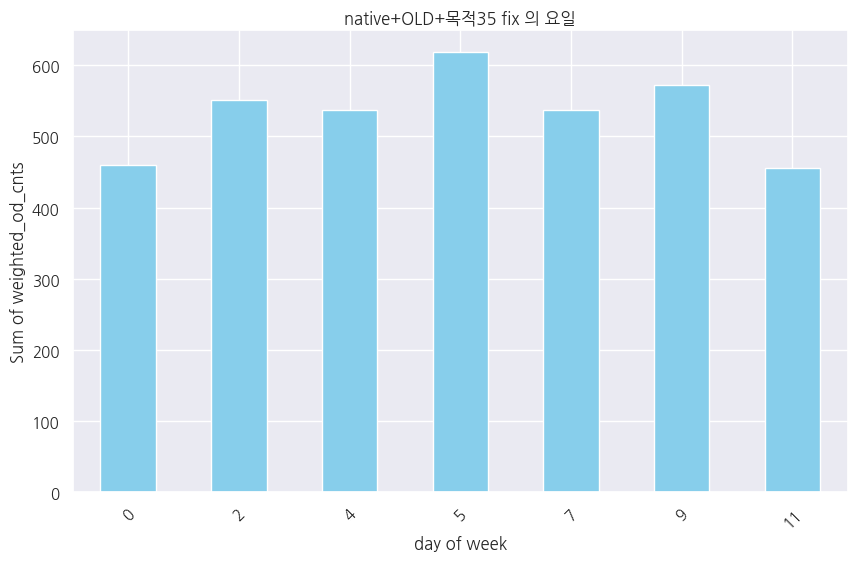

In [ ]:
# 막대 그래프 그리기
print(old_data_grouped)
plt.figure(figsize=(10, 6))
old_data_grouped['adjusted_weighted_od_cnts'].plot(kind='bar', color='skyblue')
plt.xlabel('day of week')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+OLD+목적35 fix 의 요일')
plt.xticks(rotation=45)
plt.show()

### 목요일

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
old_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['4', '5'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))&
                      (wonju['day_of_week']=='3')]

old_data_grouped = old_data.groupby(['end_time', 'is_holiday', 'day_of_week']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
old_data_grouped['weighted_od_cnts'] = old_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

old_time = old_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/6
old_time.head(20)

,weighted_od_cnts
end_time,
08,6.598889
09,38.768333
10,87.137917
11,75.314861
12,63.014028
13,82.703472
14,53.000139
15,51.537778
16,34.705694


end_time
08     6.598889
09    38.768333
10    87.137917
11    75.314861
12    63.014028
13    82.703472
14    53.000139
15    51.537778
16    34.705694
17    26.131389
18    47.907083
19    26.548333
20    11.780833
21     5.721667
22     4.366667
23     2.853333
Name: weighted_od_cnts, dtype: float64


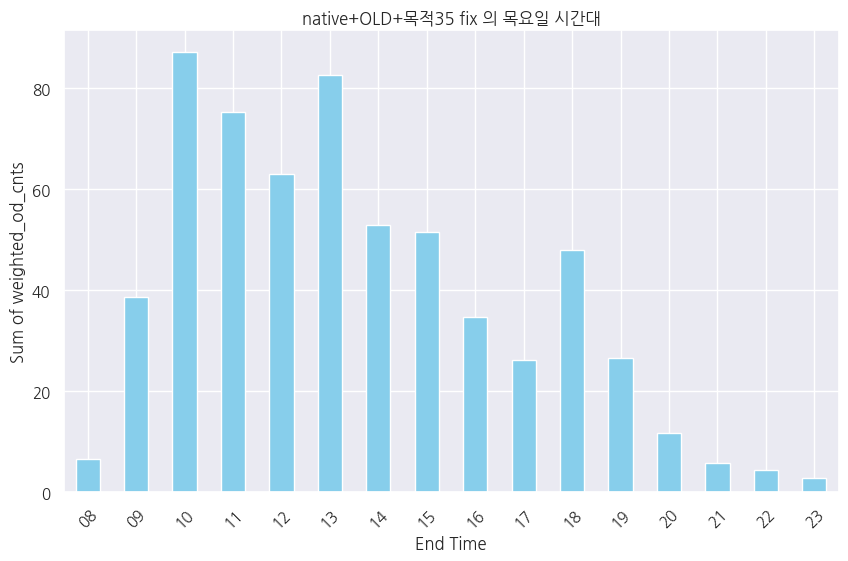

In [ ]:
# 막대 그래프 그리기
print(old_time)
plt.figure(figsize=(10, 6))
old_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+OLD+목적35 fix 의 목요일 시간대')
plt.xticks(rotation=45)
plt.show()

### 토요일

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
old_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['4', '5'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))&
                      (wonju['day_of_week']=='5')]

old_data_grouped = old_data.groupby(['end_time', 'is_holiday', 'day_of_week']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
old_data_grouped['weighted_od_cnts'] = old_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

old_time = old_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/7
old_time.head(20)

,weighted_od_cnts
end_time,
08,5.779524
09,27.908810
10,68.190833
11,48.040238
12,62.983095
13,67.685000
14,60.073214
15,44.098690
16,27.981310


end_time
08     5.779524
09    27.908810
10    68.190833
11    48.040238
12    62.983095
13    67.685000
14    60.073214
15    44.098690
16    27.981310
17    27.462500
18    44.066429
19    34.232262
20    32.164881
21    13.632381
22     5.536905
23     2.703810
Name: weighted_od_cnts, dtype: float64


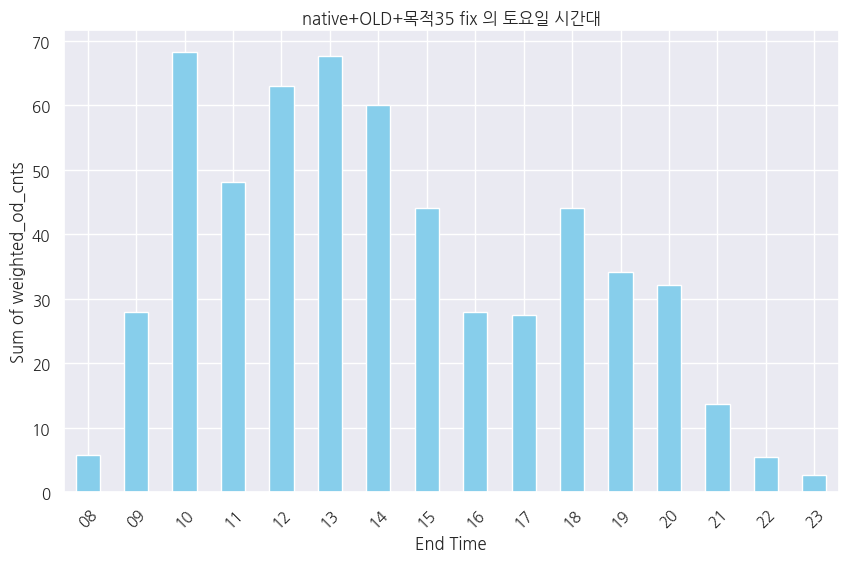

In [ ]:
# 막대 그래프 그리기
print(old_time)
plt.figure(figsize=(10, 6))
old_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+OLD+목적35 fix 의 토요일 시간대')
plt.xticks(rotation=45)
plt.show()

### 시간대별 보기

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
old_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['4', '5'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

old_data_grouped = old_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
old_data_grouped['weighted_od_cnts'] = old_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

old_time = old_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08     4.431637
09    33.707578
10    82.765019
11    56.097759
12    52.353800
13    67.755878
14    53.778637
15    42.665844
16    29.051052
17    24.376933
18    36.928041
19    25.620970
20    13.020319
21     5.906652
22     2.282474
23     1.502148
Name: weighted_od_cnts, dtype: float64


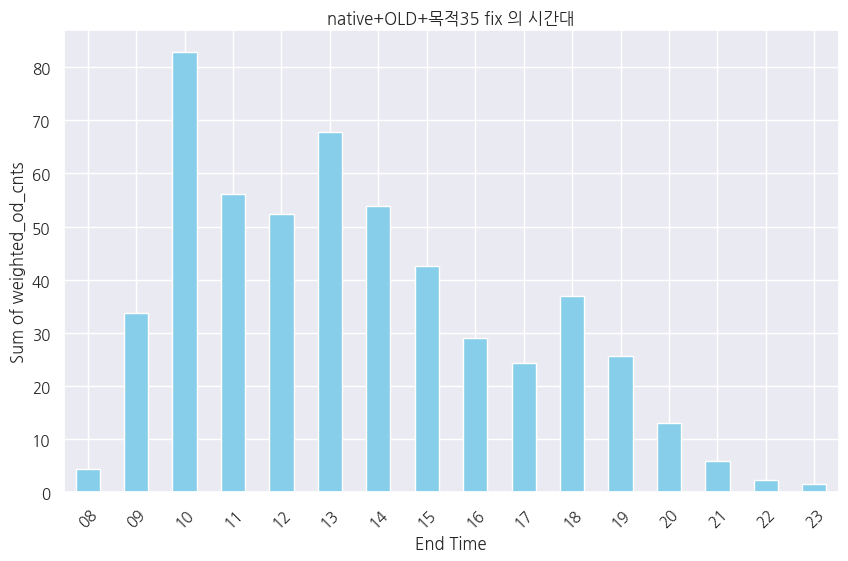

In [ ]:
# 막대 그래프 그리기
print(old_time)
plt.figure(figsize=(10, 6))
old_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+OLD+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
old_data = wonju[(wonju['native_1'] == '1') &
                      (wonju['age'].isin(['4', '5'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('0', '1', '2')))]

old_data_grouped = old_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
old_data_grouped['weighted_od_cnts'] = old_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

old_time = old_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08    480.713541
09    239.945478
10    127.226130
11    135.782019
12    196.886415
13    166.063852
14    127.845078
15    122.767304
16    128.115881
17    150.479715
18    178.851252
19    133.588385
20    119.925456
21     98.364841
22     59.547526
23     16.893304
Name: weighted_od_cnts, dtype: float64


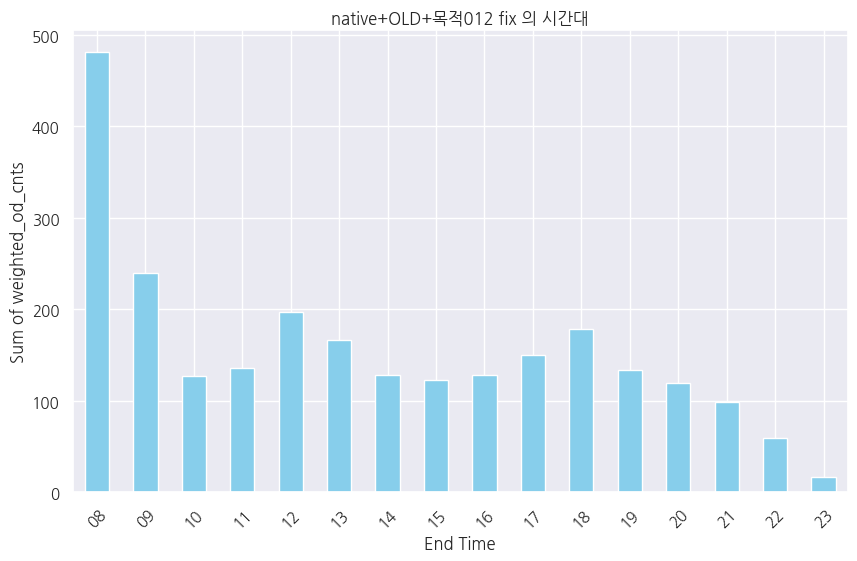

In [ ]:
# 막대 그래프 그리기
print(old_time)
plt.figure(figsize=(10, 6))
old_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('native+OLD+목적012 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

# 시나리오 2

In [ ]:
holiday0 = wonju[wonju['is_holiday']=='0']
holiday1 = wonju[wonju['is_holiday']=='1']
holiday2 = wonju[wonju['is_holiday']=='2']

holiday0_012 = holiday0[holiday0['purpose_combi'].astype(str).str.endswith(('0', '1','2'))]
holiday1_012 = holiday1[holiday1['purpose_combi'].astype(str).str.endswith(('0', '1','2'))]
holiday2_012 = holiday2[holiday2['purpose_combi'].astype(str).str.endswith(('0', '1','2'))]

holiday0_35 = holiday0[holiday0['purpose_combi'].astype(str).str.endswith(('3','5'))]
holiday1_35 = holiday1[holiday1['purpose_combi'].astype(str).str.endswith(('3','5'))]
holiday2_35 = holiday2[holiday2['purpose_combi'].astype(str).str.endswith(('3','5'))]


### holiday0_012

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
holiday0_data = holiday0_012

holiday0_data_grouped = holiday0_data.groupby(['day_of_week', 'is_holiday', 'end_time']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
holiday0_data_grouped['weighted_od_cnts'] = holiday0_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

holiday0_data_grouped = holiday0_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/26
holiday0_data_grouped.head(20)

,weighted_od_cnts
end_time,
08,1763.754949
09,606.062154
10,314.438923
11,343.677923
12,563.414968
13,535.147955
14,369.823167
15,444.608404
16,637.048878


end_time
08    1763.754949
09     606.062154
10     314.438923
11     343.677923
12     563.414968
13     535.147955
14     369.823167
15     444.608404
16     637.048878
17     594.268615
18     590.903744
19     466.132788
20     402.742647
21     344.635429
22     303.599622
23     112.343506
Name: weighted_od_cnts, dtype: float64


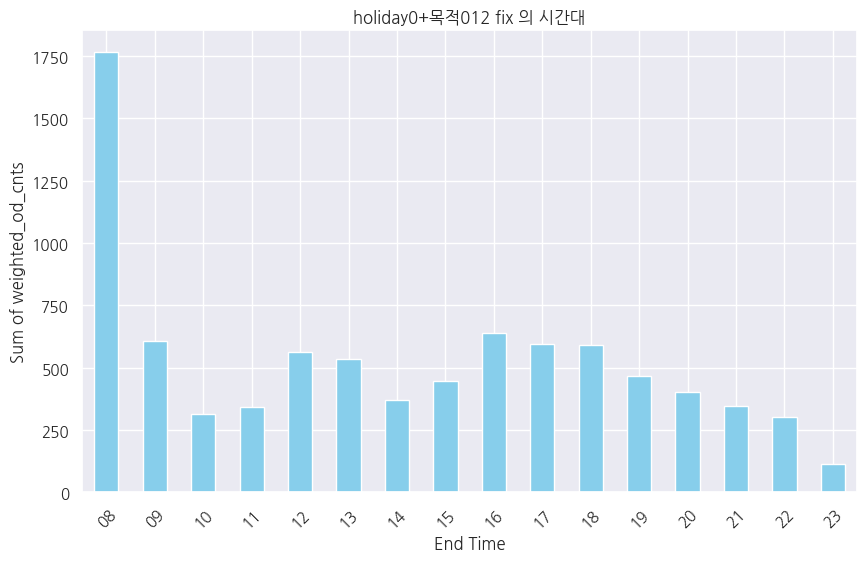

In [ ]:
# 막대 그래프 그리기
print(holiday0_data_grouped)
plt.figure(figsize=(10, 6))
holiday0_data_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('holiday0+목적012 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

### holiday1_012

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
holiday1_data = holiday1_012

holiday1_data_grouped = holiday1_data.groupby(['day_of_week', 'is_holiday', 'end_time']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
holiday1_data_grouped['weighted_od_cnts'] = holiday1_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

holiday1_data_grouped = holiday1_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/10
holiday1_data_grouped.head(20)

,weighted_od_cnts
end_time,
08,265.637167
09,305.734000
10,284.305250
11,247.397750
12,305.018583
13,338.183250
14,302.067500
15,303.502250
16,316.909750


end_time
08    265.637167
09    305.734000
10    284.305250
11    247.397750
12    305.018583
13    338.183250
14    302.067500
15    303.502250
16    316.909750
17    339.858250
18    373.613167
19    358.911000
20    336.205167
21    308.809250
22    244.262250
23    102.835750
Name: weighted_od_cnts, dtype: float64


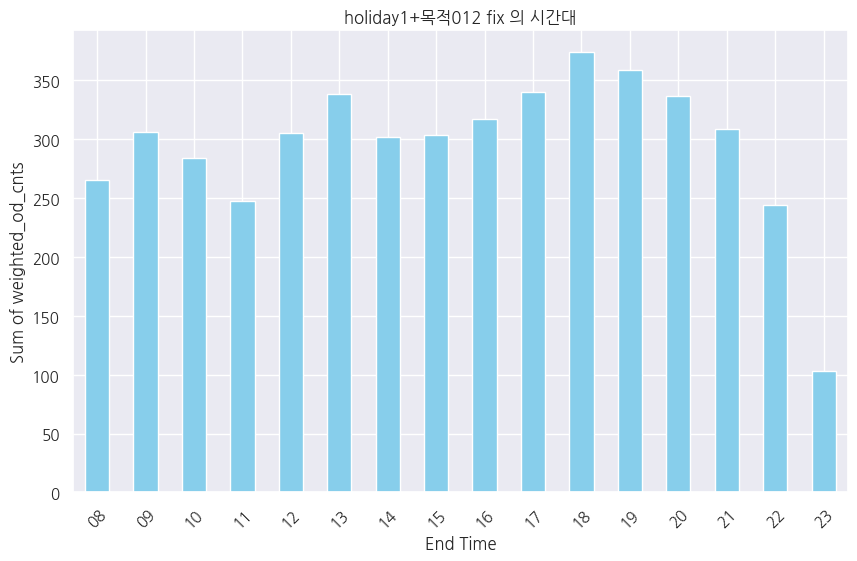

In [ ]:
# 막대 그래프 그리기
print(holiday1_data_grouped)
plt.figure(figsize=(10, 6))
holiday1_data_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('holiday1+목적012 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

### holiday2_012

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
holiday2_data = holiday2_012

holiday2_data_grouped = holiday2_data.groupby(['day_of_week', 'is_holiday', 'end_time']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
holiday2_data_grouped['weighted_od_cnts'] = holiday2_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

holiday2_data_grouped = holiday2_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/9
holiday2_data_grouped.head(20)

,weighted_od_cnts
end_time,
08,134.841630
09,186.919463
10,186.548926
11,185.093111
12,187.243148
13,227.420037
14,212.469889
15,227.952593
16,219.155389


end_time
08    134.841630
09    186.919463
10    186.548926
11    185.093111
12    187.243148
13    227.420037
14    212.469889
15    227.952593
16    219.155389
17    262.750556
18    248.259593
19    236.708667
20    233.043333
21    212.125815
22    154.968037
23     72.673667
Name: weighted_od_cnts, dtype: float64


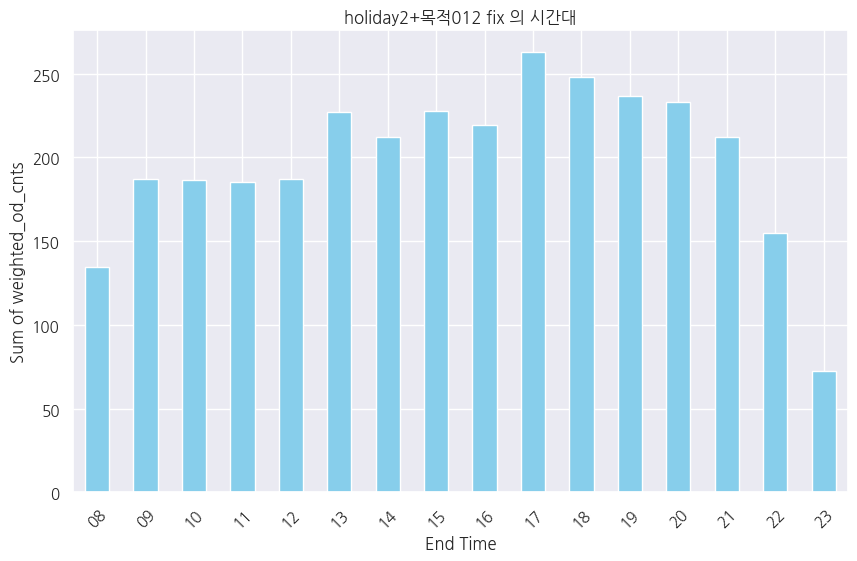

In [ ]:
# 막대 그래프 그리기
print(holiday2_data_grouped)
plt.figure(figsize=(10, 6))
holiday2_data_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('holiday2+목적012 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

### holiday0_35

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
holiday0_data = holiday0_35

holiday0_data_grouped = holiday0_data.groupby(['day_of_week', 'is_holiday', 'end_time']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
holiday0_data_grouped['weighted_od_cnts'] = holiday0_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

holiday0_data_grouped = holiday0_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/26
holiday0_data_grouped.head(20)

,weighted_od_cnts
end_time,
08,6.247821
09,99.611571
10,161.935385
11,131.507929
12,123.602897
13,167.955429
14,141.084147
15,152.541256
16,165.119256


end_time
08      6.247821
09     99.611571
10    161.935385
11    131.507929
12    123.602897
13    167.955429
14    141.084147
15    152.541256
16    165.119256
17    125.179750
18    125.687487
19     88.292968
20     51.717179
21     25.699987
22     10.371378
23      5.420936
Name: weighted_od_cnts, dtype: float64


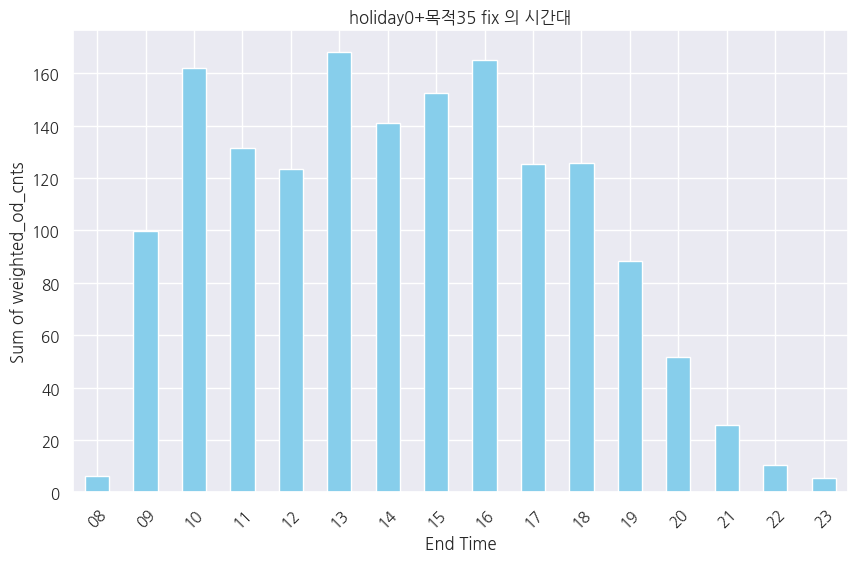

In [ ]:
# 막대 그래프 그리기
print(holiday0_data_grouped)
plt.figure(figsize=(10, 6))
holiday0_data_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('holiday0+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

### holiday1_35

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
holiday1_data = holiday1_35

holiday1_data_grouped = holiday1_data.groupby(['day_of_week', 'is_holiday', 'end_time']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
holiday1_data_grouped['weighted_od_cnts'] = holiday1_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

holiday1_data_grouped = holiday1_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/10
holiday1_data_grouped.head(20)

,weighted_od_cnts
end_time,
08,5.891167
09,84.908167
10,240.274083
11,208.648500
12,198.034667
13,242.468583
14,192.640083
15,175.668250
16,144.293333


end_time
08      5.891167
09     84.908167
10    240.274083
11    208.648500
12    198.034667
13    242.468583
14    192.640083
15    175.668250
16    144.293333
17    143.129750
18    139.897833
19     92.983917
20     77.201083
21     42.497833
22     12.605333
23      6.776333
Name: weighted_od_cnts, dtype: float64


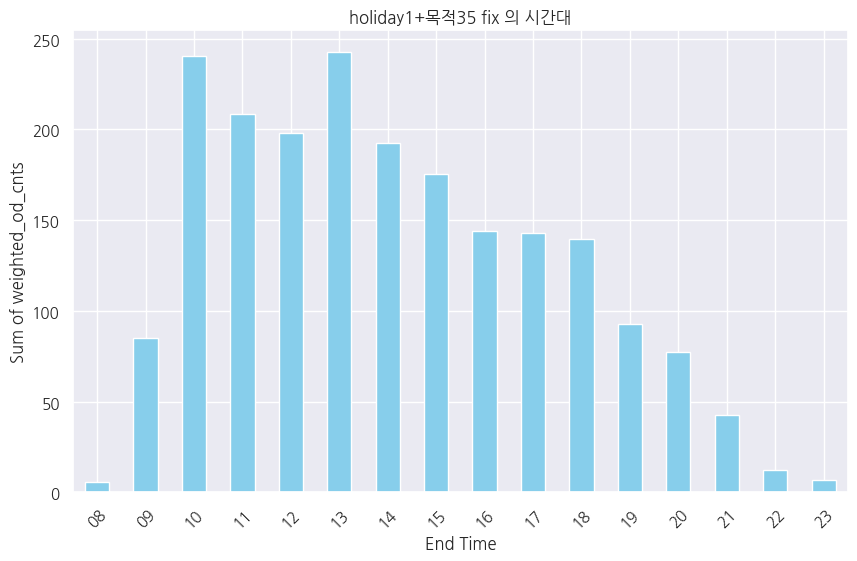

In [ ]:
# 막대 그래프 그리기
print(holiday1_data_grouped)
plt.figure(figsize=(10, 6))
holiday1_data_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('holiday1+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

### holiday2_35

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
holiday2_data = holiday2_35

holiday2_data_grouped = holiday2_data.groupby(['day_of_week', 'is_holiday', 'end_time']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
holiday2_data_grouped['weighted_od_cnts'] = holiday2_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

holiday2_data_grouped = holiday2_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/9
holiday2_data_grouped.head(20)

,weighted_od_cnts
end_time,
08,19.599444
09,75.077222
10,195.387778
11,207.920000
12,230.566111
13,263.305556
14,254.516667
15,217.425000
16,183.932778


end_time
08     19.599444
09     75.077222
10    195.387778
11    207.920000
12    230.566111
13    263.305556
14    254.516667
15    217.425000
16    183.932778
17    200.826111
18    169.156667
19    115.679444
20     77.480000
21     51.374444
22     31.876667
23     22.885556
Name: weighted_od_cnts, dtype: float64


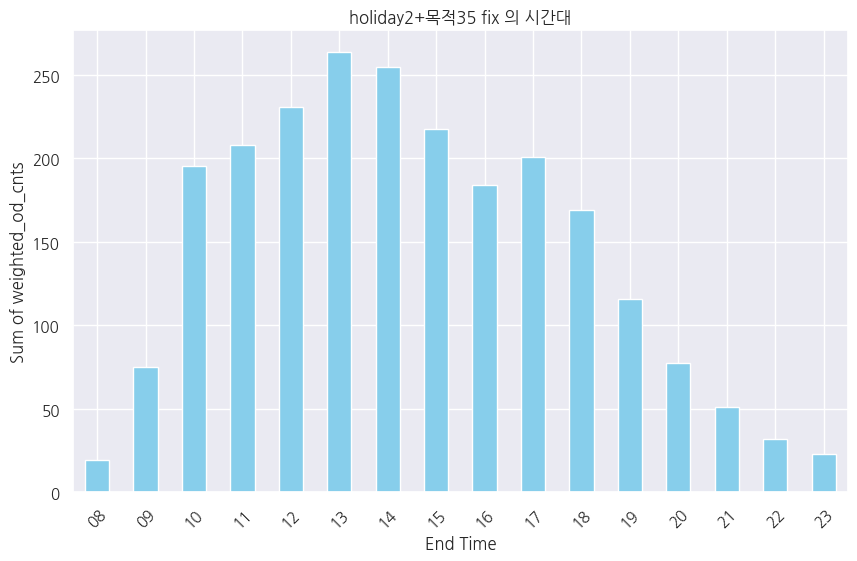

In [ ]:
# 막대 그래프 그리기
print(holiday2_data_grouped)
plt.figure(figsize=(10, 6))
holiday2_data_grouped.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('holiday2+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

# 강릉 vs 원주

### 원주 시간대별 보기

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = wonju[(wonju['age'].isin(['2', '3'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

mz_data_grouped = mz_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08     2.100726
09    14.906544
10    20.386700
11    18.245378
12    16.749574
13    20.742470
14    16.793078
15    15.484111
16    11.872870
17    13.122030
18    21.958807
19    14.511581
20     9.365930
21     6.616044
22     3.357900
23     0.936089
Name: weighted_od_cnts, dtype: float64


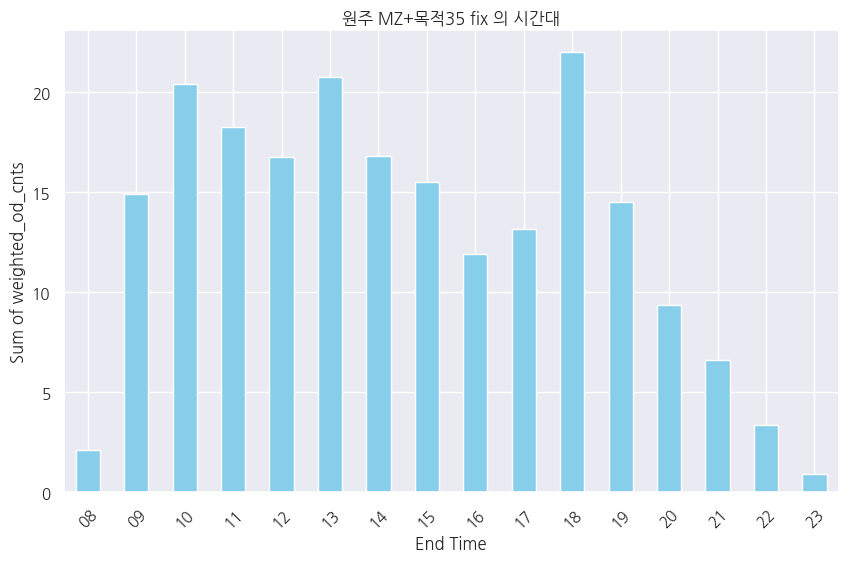

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('원주 MZ+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

old임!!!!

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = wonju[(wonju['age'].isin(['4', '5'])) &
                      (wonju['purpose_combi'].astype(str).str.endswith(('3', '5')))]

mz_data_grouped = mz_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08     4.431637
09    38.302156
10    87.636381
11    60.748452
12    55.504807
13    72.080085
14    57.657004
15    46.172667
16    31.672496
17    26.965496
18    40.934444
19    28.992630
20    13.807259
21     6.054430
22     2.850874
23     2.124193
Name: weighted_od_cnts, dtype: float64


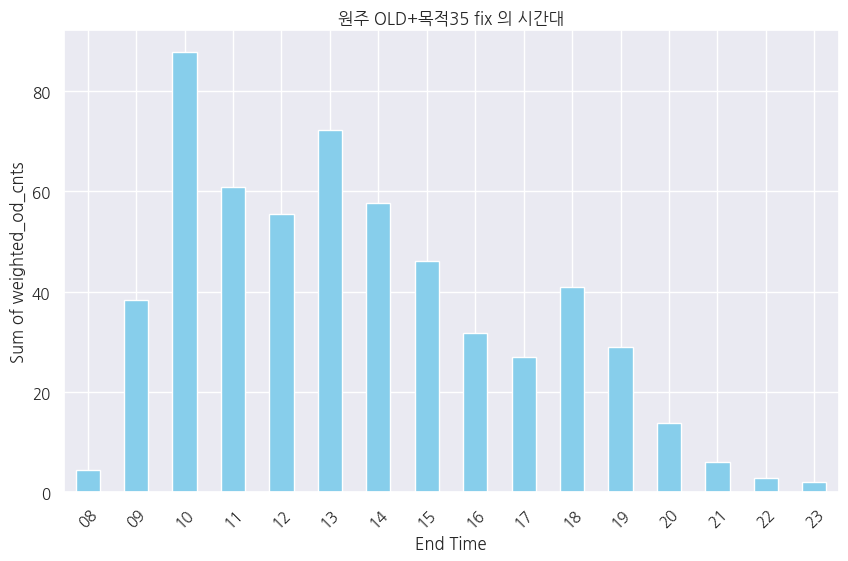

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('원주 OLD+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

강릉

In [ ]:
gang = pd.read_csv("/content/drive/MyDrive/빅콘테스트와플핑/0.데이터/강릉 데이터/last_predict_result.csv")
gang = gang.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
gang.head()

<ipython-input-64-bb7f0d723709>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gang = gang.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


,native_1,end_time,gender,age,day_of_week,purpose_combi,is_holiday,predicted_od_cnts
0,0,08,0,1,5,04,1,8.912
1,0,08,0,1,5,55,2,4.445
2,0,08,0,1,6,40,1,1.324
3,0,08,0,1,6,44,2,18.712
4,0,08,0,2,6,40,1,1.068


### 강릉 시간대별 보기

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = gang[(gang['age'].isin(['2', '3'])) &
                      (gang['purpose_combi'].astype(str).str.endswith(('3', '5')))]

mz_data_grouped = mz_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08     38.111237
09    104.745096
10    211.002578
11    424.656015
12    379.726793
13    373.395848
14    339.892674
15    331.559744
16    307.779741
17    362.310733
18    394.553385
19    288.816989
20    182.766252
21    118.295226
22     83.390637
23     42.646152
Name: weighted_od_cnts, dtype: float64


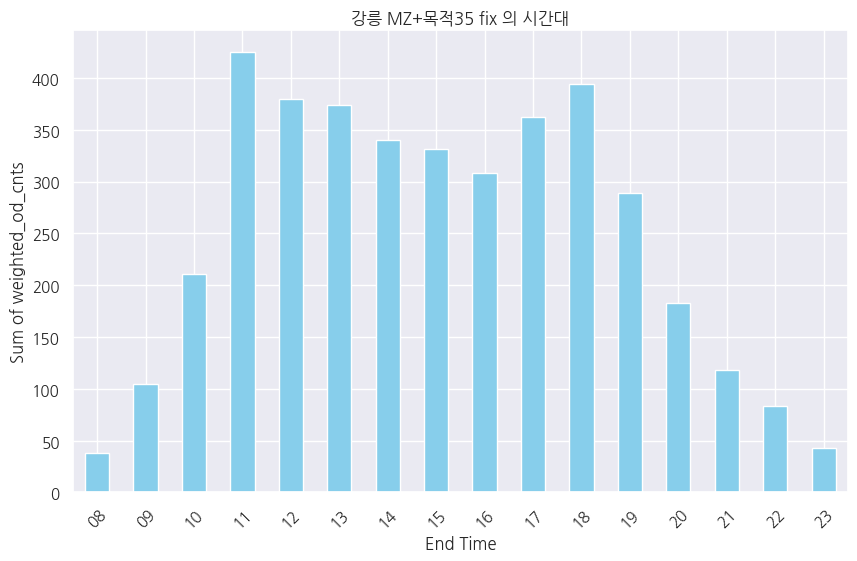

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('강릉 MZ+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()

old임!!!!

In [ ]:
# 요일과 공휴일 여부에 따른 가중치 설정 함수
def apply_weight(day_of_week, is_holiday):
    # 요일과 공휴일 여부에 따른 가중치 반환
    if day_of_week == '0':  # 월요일
        return 2 if is_holiday == '2' else 4
    elif day_of_week == '1':  # 화요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '2':  # 수요일
        return 6  # 수요일은 공휴일과 관계 없이 6
    elif day_of_week == '3':  # 목요일
        return 1 if is_holiday == '2' else 5
    elif day_of_week == '4':  # 금요일
        return 1 if is_holiday == '2' else 6
    elif day_of_week == '5':  # 토요일
        return 2 if is_holiday == '2' else 5
    elif day_of_week == '6':  # 일요일
        return 2 if is_holiday == '2' else 5

# native_1이 1이고, age가 '1', '2', '3'이며, purpose_combi가 '3' 또는 '5'로 끝나는 행 필터링
mz_data = gang[(gang['age'].isin(['4', '5'])) &
                      (gang['purpose_combi'].astype(str).str.endswith(('3', '5')))]

mz_data_grouped = mz_data.groupby(['end_time','day_of_week', 'is_holiday']).agg({'predicted_od_cnts': 'sum'}).reset_index()


# 'day_of_week'과 'is_holiday'를 기준으로 가중치를 적용하여 'weighted_od_cnts' 생성
mz_data_grouped['weighted_od_cnts'] = mz_data_grouped.apply(
    lambda row: row['predicted_od_cnts'] * apply_weight(str(row['day_of_week']), str(row['is_holiday'])), axis=1
)

mz_time = mz_data_grouped.groupby('end_time')['weighted_od_cnts'].sum()/45

end_time
08     30.418681
09     95.040663
10    158.042304
11    188.349737
12    183.114693
13    202.413548
14    167.905444
15    147.305044
16    139.406281
17    165.679737
18    205.084352
19    144.203993
20     78.515407
21     49.530589
22     37.469907
23     12.709496
Name: weighted_od_cnts, dtype: float64


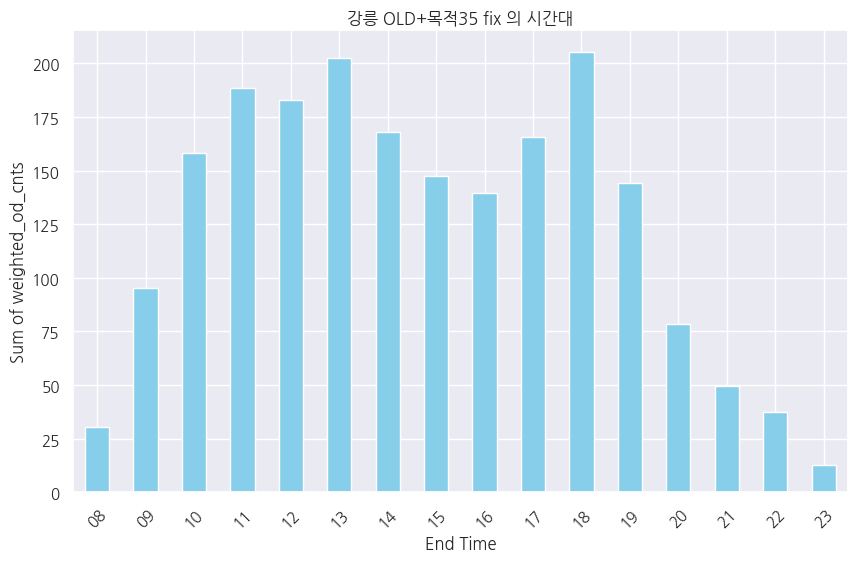

In [ ]:
# 막대 그래프 그리기
print(mz_time)
plt.figure(figsize=(10, 6))
mz_time.plot(kind='bar', color='skyblue')
plt.xlabel('End Time')
plt.ylabel('Sum of weighted_od_cnts')
plt.title('강릉 OLD+목적35 fix 의 시간대')
plt.xticks(rotation=45)
plt.show()